In [1]:
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from sklearn.datasets import make_classification, make_circles
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.metrics import accuracy_score

import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')
import time
from sklearn.model_selection import train_test_split

In [2]:
np.random.seed(42)
# делаем бустрэп. на вход передаем данные: признаки, целевые значения и кол-во подвыборок
# сколько мы хотим получить на выходе подвыборок
def get_bootstrap(data, labels, N):
    #получаем индексы объектов
    n_samples = data.shape[0] # размер совпадает с исходной выборкой
    # делаем заготовку для будущих бустрапированных подвыборок
    bootstrap = []

    # проходимся по количеству будущих деревьев нашей композиции
    for i in range(N):

        #генерируем индексы в том количестве сколько объектов у нас было
        #сколько объектов будет в бустрапированной подвыборке
        sample_index = np.random.randint(0, n_samples, size=n_samples)
        #признаки для обучения
        b_data = data[sample_index]
        #получем целевые значения для обучения
        b_labels = labels[sample_index]

        #добавляем в бустрапированную выборк
        #на выходе получаем кортеж из признаков и целевых значений
        bootstrap.append((b_data, b_labels))

    return bootstrap

In [3]:
#метод случайных подпространств
#получение признаков для каждого уникальног вопроса
#на вход подаем количество признаков
def get_subsample(len_sample):
    # будем сохранять не сами признаки, а их индексы
    sample_indexes = list(range(len_sample))

    #берем то количество признаков, которое нам рекомендовано
    #для классификации по формуле
    len_subsample = int(np.round(np.sqrt(len_sample)))

    # берем признаки без повторения, т.к. replace=False
    subsample = np.random.choice(sample_indexes, size=len_subsample, replace=False)

    return subsample

In [4]:
class Node:

    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

# И класс терминального узла (листа)

class Leaf:

    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()

    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1

        # найдем класс, количество объектов которого будет максимальным в этом листе и вернем его
        prediction = max(classes, key=classes.get)
        return prediction

In [5]:
# Расчет критерия Джини
def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1

    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2

    return impurity

# Расчет прироста

# Расчет  информации
def gain(left_labels, right_labels, root_gini):

    # доля выборки, ушедшая в левое поддерево
    #нормируем критерий информативности по подвыборкам
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    #перемножаем на критерий Джини какая доля объектов ушла в левую подвыборку, какая доля ушла в правую
    # вычитаем это из критерия Джини вершины
    #т.е. сколько полезной информации добавилось в зависимоти от этого вопроса
    return root_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [6]:
# Разбиение датасета в узле

def split(data, labels, column_index, t):
    left = np.where(data[:, column_index] <= t)
    right = np.where(data[:, column_index] > t)

    true_data = data[left]
    false_data = data[right]

    true_labels = labels[left]
    false_labels = labels[right]

    return true_data, false_data, true_labels, false_labels

# Нахождение наилучшего разбиения

def find_best_split(data, labels):

    #  обозначим минимальное количество объектов в узле
    #min_leaf_samples = 5

    #посчитали критерий Джини в вершине
    root_gini = gini(labels)

    #обнулили прирост
    best_gain = 0
    #нет лучшего порогового значения
    best_t = None
    #нет лучшего признака
    best_index = None

    #получили количество признаков
    n_features = data.shape[1]

    #генерируем случайные признаки на которых будем выбирать самый лучший вопрос
    feature_subsample_indices = get_subsample(n_features) # выбираем случайные признаки

    #проходимя по признакам
    for index in feature_subsample_indices:
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique(data[:, index])

        #проходимся по уникальным значениям
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
#             if len(true_data) < min_leaf_samples or len(false_data) < min_leaf_samples:
#                 continue

            current_gain = gain(true_labels, false_labels, root_gini)

            #  выбираем порог, на котором получается максимальный прирост качества
            #если прирост информации оказался лучше чем был, то все характеристики перезапиываем
            if current_gain > best_gain:
                best_gain, best_t, best_index = current_gain, t, index

    return best_gain, best_t, best_index

In [7]:
# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels):

    gain, t, index = find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if gain == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels)

    #print(time.time(), true_branch)
    false_branch = build_tree(false_data, false_labels)

    #print(time.time(), false_branch)

    #Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [8]:
#строим случайный лес
#на вход передаем данные, целевые значения и количнство деревьев
def random_forest(data, labels, n_trees):
    #список для будущих деревьев
    forest = []
    #формируем бустрапированые выборки, на которых хотим обучать деревья
    bootstrap = get_bootstrap(data, labels, n_trees)

    for b_data, b_labels in bootstrap:
        #добавляем в список обученные деревья
        forest.append(build_tree(b_data, b_labels))

    return forest

In [9]:
def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer
    #если узел не листок, сравниваем его с пороговым значением
    #если условие удовлетворяется, то рекурсовно идем на классификацию объекта
    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

def predict(data, tree):

    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes


In [10]:
# предсказание голосованием деревьев
#на вход поступает список деревьев и данные
def tree_vote(forest, data):

    # добавим предсказания всех деревьев в список
    predictions = []
    #проходимся по все деревьям, получаем дерево и предстказание по нему
    for tree in forest:
        predictions.append(predict(data, tree))
    print(predictions)

    # сформируем список с предсказаниями для каждого объекта
    predictions_per_object = list(zip(*predictions))
    print(predictions_per_object)

    # выберем в качестве итогового предсказания для каждого объекта то,
    # за которое проголосовало большинство деревьев
    voted_predictions = []
    for obj in predictions_per_object:
        voted_predictions.append(max(set(obj), key=obj.count))

    return voted_predictions

In [11]:
# Введем функцию подсчета точности как доли правильных ответов
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [12]:
def plot_decision_boundary(forest, data, labels, ax, n_trees):
    x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
    y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))
    grid = np.c_[xx.ravel(), yy.ravel()]
    predictions = tree_vote(forest, grid)
    predictions = np.array(predictions).reshape(xx.shape)

    ax.contourf(xx, yy, predictions, alpha=0.3, cmap=light_colors)
    ax.scatter(data[:, 0], data[:, 1], c=labels, cmap=colors)
    ax.set_title(f"{n_trees} Trees")

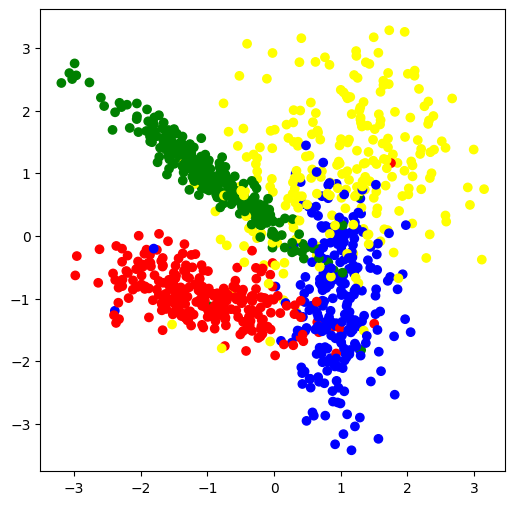

In [14]:
classification_data, classification_labels = make_classification(n_samples=1000,
                                                                 n_features=2, n_informative=2,
                                                                 n_classes=4, n_redundant=0,
                                                                 n_clusters_per_class=1, random_state=23)

plt.figure(figsize=(6, 6))
colors = ListedColormap(['red', 'blue', 'green', 'yellow'])
light_colors = ListedColormap(['lightcoral', 'lightblue', 'lightgreen', 'lightyellow'])


plt.scatter(classification_data[:, 0], classification_data[:, 1],
              c=classification_labels, cmap=colors)

plt.show()

[[0, 0, 2, 2, 3, 2, 3, 2, 1, 1, 3, 1, 0, 3, 2, 0, 3, 3, 3, 3, 3, 2, 2, 0, 0, 2, 2, 1, 3, 3, 0, 0, 3, 2, 1, 1, 0, 3, 2, 3, 0, 1, 3, 1, 0, 2, 1, 0, 1, 2, 3, 3, 3, 3, 1, 3, 2, 1, 1, 0, 1, 3, 2, 2, 0, 3, 2, 3, 0, 2, 2, 2, 1, 0, 1, 2, 3, 1, 2, 3, 0, 1, 3, 2, 1, 1, 3, 1, 3, 2, 3, 3, 2, 0, 0, 0, 3, 3, 2, 0, 2, 2, 3, 1, 1, 1, 0, 3, 1, 0, 1, 2, 0, 3, 0, 1, 1, 0, 2, 2, 2, 0, 0, 2, 2, 2, 0, 2, 3, 2, 0, 0, 1, 0, 1, 0, 3, 2, 2, 1, 2, 0, 1, 2, 3, 0, 1, 3, 3, 1, 0, 1, 3, 0, 1, 0, 1, 3, 2, 1, 1, 3, 3, 1, 1, 3, 0, 1, 1, 2, 1, 1, 0, 2, 0, 1, 3, 3, 0, 1, 1, 3, 3, 2, 3, 3, 0, 2, 1, 0, 1, 2, 3, 0, 3, 2, 3, 1, 3, 3, 2, 3, 3, 3, 0, 2, 1, 2, 0, 3, 2, 3, 2, 3, 2, 2, 0, 1, 2, 1, 0, 2, 1, 3, 2, 0, 1, 0, 1, 3, 1, 2, 2, 1, 2, 0, 2, 3, 2, 0, 3, 2, 3, 1, 3, 3, 1, 3, 3, 2, 2, 1, 1, 2, 2, 2, 1, 3, 0, 3, 3, 1, 1, 0, 3, 1, 0, 2, 1, 0, 2, 2, 2, 3, 2, 0, 0, 2, 2, 3, 0, 1, 3, 3, 3, 1, 2, 0, 2, 1, 0, 2, 1, 3, 0, 3, 1, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 3, 0, 3, 0, 1, 3, 3, 1, 2, 2, 2, 1, 2, 2, 2, 0, 1, 1, 1, 2, 2, 1, 2, 3, 1,

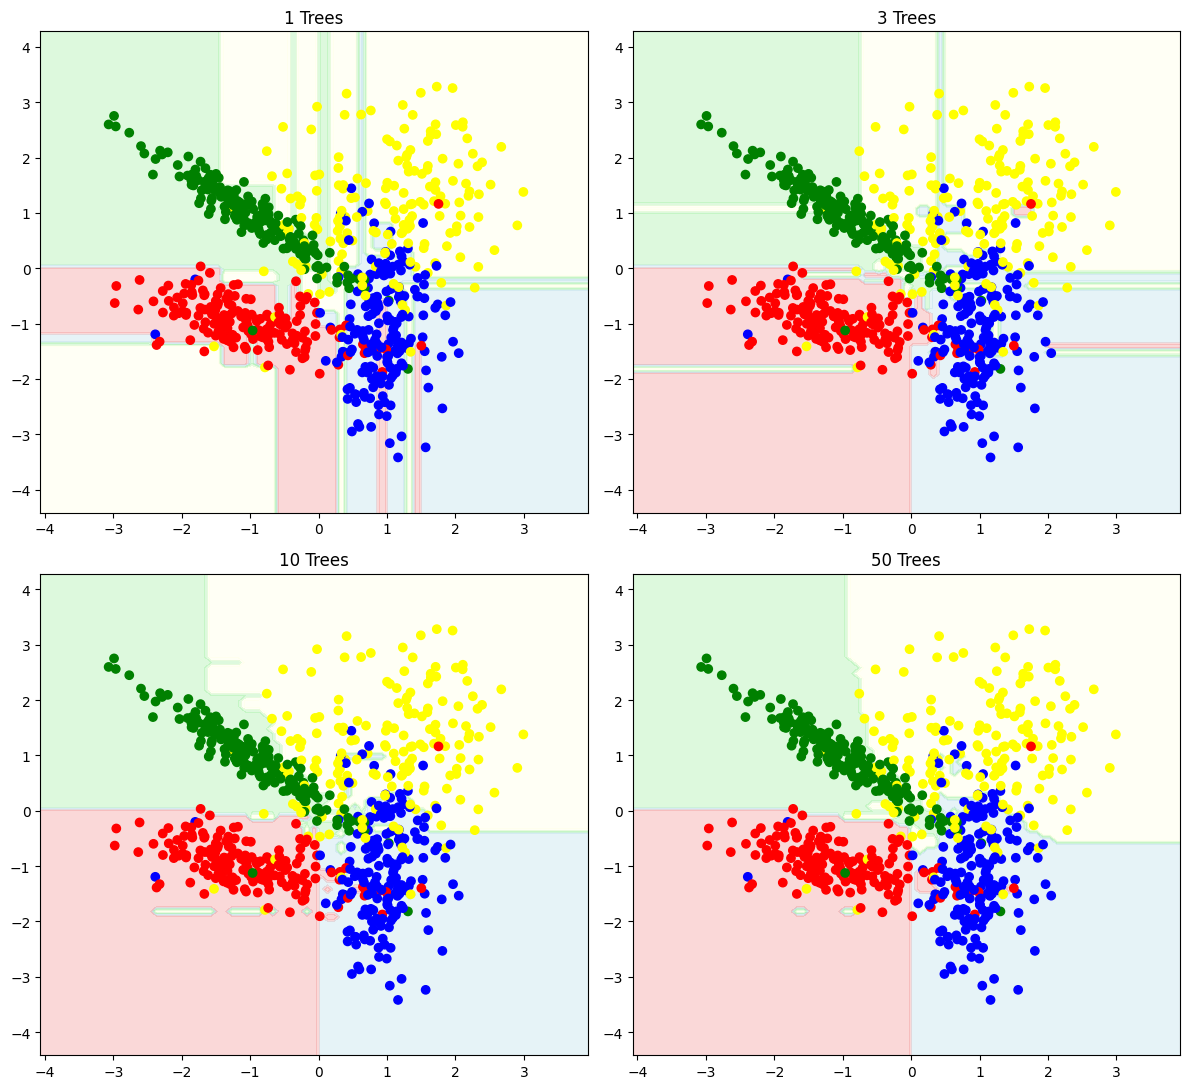

In [15]:
train_data, test_data, train_labels, test_labels = train_test_split(classification_data,
                                                                    classification_labels,
                                                                    test_size=0.3,
                                                                    random_state=1)

fig, axes = plt.subplots(2, 2, figsize=(12, 11))

n_trees_list = [1, 3, 10, 50]
axes = axes.flatten()


for i, n_trees in enumerate(n_trees_list):
    my_forest = random_forest(train_data, train_labels, n_trees)

    train_answers = tree_vote(my_forest, train_data)
    test_answers = tree_vote(my_forest, test_data)

    train_accuracy = accuracy_metric(train_labels, train_answers)
    test_accuracy = accuracy_metric(test_labels, test_answers)

    print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')
    print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}')

    plot_decision_boundary(my_forest, train_data, train_labels, axes[i], n_trees)

plt.tight_layout()
plt.show()
